# Исследование поездок пользователей сервиса аренды самокатов

### Цель и задачи исследования

**Цель:** анализ особенностей пользования сервисом аренды самокатов клиентами с подпиской и без подписки.

**Задачи проекта:**
- исследовательский анализ данных о пользователях приложения и их поездках на самокатах сервиса;
- проверка гипотез от продакт-менеджеров.

**План работ:**
1. Сделать общий анализ данных о пользователях, их поездках и подписках;
2. Проверить и заполнить пропуски данных там, где это необходимо;
3. Заменить типы данных на корректные;
4. Проверить наличие явных и неявных дубликатов и очистить от них данные при необходимости;
5. Рассчитать и добавить новые параметры;
6. Провести общий анализ пользователей с подписками и без, а также особенностей их поездок;
7. Проверить гипотезы о длительности поездки пользователями с разными типами подписки, о средней дистанции пользователей с подпиской и о сумме ежемесячной выручки от пользователей с подпиской и без.

В основных данных есть информация о пользователях, их поездках и подписках.

In [180]:
import pandas as pd

import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st

### Загрузка данных

In [181]:
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv')
subscriptions = pd.read_csv('subscriptions_go.csv')

In [182]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [183]:
rides.info()
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [184]:
subscriptions.info()
subscriptions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Вывод:
 - в работу взяли 3 датафрейма, содержащие данные о пользователях, их поездках и типах подписок в 5, 4 и 4 колонки соответственно; 
 - данные о дате поездки в таблице rides имеют некорректный тип object, изменим его на datetime в дальнейшем. 

### Предобработка данных

Приведем столбцы к нужным типам данных, создадим новый столбей с номером месяца на основе столбца date,
проверим наличие пропущенных значений и дубликатов в датафреймах и обработаем их, если такие значения присутствуют.

Приведем стобец `date` в таблице `rides` в корректному типу данных datetime.

In [185]:
rides['date'] = pd.to_datetime(
    rides['date'], format='%Y-%m-%dT%H:%M:%S')

Создадим столбец в таблице `rides` с номером месяца поездки.

In [186]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [187]:
print(rides['date'].min())
print(rides['date'].max())

2021-01-01 00:00:00
2021-12-30 00:00:00


В работу взяли данные о поездках пользователей с 1 января по 30 декабря 2021 года.

Проверим тип данных стобца date и корректность добавления столбца month.

In [188]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


Проверим пропуски во всех датафреймах.

In [189]:
print(users.isna().sum())
print()
print(rides.isna().sum())
subscriptions.isna().sum() 

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64


subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков данных не обнаружено.

Проверим наличие явных строк-дубликатов.

In [190]:
users.duplicated().sum()

31

In [191]:
users[users.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


В таблице `users` обнаружили 31 строку-дубликат, удалим дублированные данные из датафрейма.

In [192]:
users = users.drop_duplicates()
users[users.duplicated()].sum()

user_id              0.0
name                 0.0
age                  0.0
city                 0.0
subscription_type    0.0
dtype: float64

In [193]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


Проверим наличие явных строк-дубликатов в данных.

In [194]:
rides[rides.duplicated()].sum(numeric_only=True)

user_id     0.0
distance    0.0
duration    0.0
month       0.0
dtype: float64

Проверим неявные дубли в данных по сочетаниям значений в столбцах 'distance' и 'duration'.

In [195]:
rides[rides.duplicated(['distance', 'duration'])]

,user_id,distance,duration,date,month


In [196]:
print(users.info())
print()
print(rides.info())
print()
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB
None

<

Вывод:
- привели столбец date к типу datetime;
- в работу взяли данные о поездках пользователей с 1 января по 30 декабря 2021 года;
- проверили наличие пропущенных значений, пропусков нет;
- проверили наличие дубликатов в датафреймах - есть полные дубли в таблице users, удалили 31 строку-дубликат;
- cоздали новый столбец с номером месяца на основе столбца date.

### Исследовательский анализ данных

Опишем общую информацию о пользователях и поездках, а также визуализируем имеющиеся данные.

In [197]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [198]:
city = users['city'].value_counts().reset_index()
city['ratio'] = round(city['city'] / city['city'].sum() *100, 1)


fig = px.bar(city, 
             x='city', 
             y='index', 
             text='city'
            )

fig.update_layout(title='Частота встречаемости городов',
                   xaxis_title='Частота встречаемости города',
                   yaxis_title='Город')
fig

In [199]:
city = users['city'].value_counts().reset_index()
city['ratio'] = round(city['city'] / city['city'].sum() *100, 1)

In [200]:
fig = px.bar(city, 
             y='ratio', 
             x='index', 
             text='ratio'
            )

fig.update_layout(title='Соотношение пользователей из разных городов',
                   xaxis_title='Город',
                   yaxis_title='Доля пользователей, %',
                 width=800,
                  height=400)
fig

В имеющейся выборке доля представленности пользователей из разных городов варьируется от 11 до 14.3%, что можно назвать примерно равными долями. Больше всего пользователей из Пятигорска (14.3%), Екатеринбурга (13.3%) и Ростова-на-Дону(12.9%). Меньше всего данных в выборке о пользователях из Москвы(11%).

In [201]:
subscription = users.groupby('subscription_type')['user_id'].count().reset_index()

fig = go.Figure(data=[go.Pie(
                        labels=subscription['subscription_type'],
                        values=subscription['user_id'])])
fig.update_layout(title='Соотношение пользователей с подпиской и без',
                  width=600,
                  height=400)
fig

In [202]:
users['age'].describe().to_frame()

,age
count,1534.000000
mean,24.903520
std,4.572367
min,12.000000
25%,22.000000
50%,25.000000
75%,28.000000
max,43.000000


In [203]:
fig = px.histogram(users,
                   x='age',
                   color='subscription_type',
                   barmode = 'overlay',
                   width=800, height=400,
                   title='Распределение возраста пользователей с подпиской и без')
fig

In [204]:
fig = px.box(users, x='subscription_type', y='age', color='subscription_type')
fig.update_layout(title='Разброс возраста пользователей с подпиской и без',
                   xaxis_title='ultra - наличие подписки, free - без подписки',
                   yaxis_title='Возраст пользователя',
                   showlegend=False
                   )
fig

В выборке представлены данные о пользователях, минимальный возраст которых - 12 лет, максимальный для пользователей без подписки - 43 года, для пользователей с подпиской чуть ниже - 38 лет. Возраст пользователей с подпиской и без подписки распределен нормально. Пик распределения для пользователей с подпиской - самое часто встречаемое значение возраста - 25 лет. Для пользователей без подписки - 24 года, но отличия не значительные и практически также часто в выборке пользователей без подписки встречаются люди в возрасте 23 и 25 лет. И именно поэтому средний возраст пользователя с подпиской и без подписки одинаков - 25 лет. 

Возрастная категория 21-28 лет - самые активные пользователи сервиса аренды самокатов без подписки.

In [205]:
fig = px.histogram(rides, x='distance',
                   width=1000, height=400,
                   title='Распределение дистанции поездки', nbins=120)
fig

Распределение расстояния, которое проезжают пользователи сервиса GoFast, имеею 3 пиковых значения - 550-750 метров, 2950-3150 и 3950 - 4050 метров. Наибольшее количество пользователей проезжают на самокате около 3 километров за 1 поездку. 

In [206]:
fig = px.histogram(rides, x='duration',
                   nbins=70,
                   width=1000, height=400,
                   title='Распределение времени поездки')
fig

Длительность поездки распределена нормально с пиком значения 17-19 минут. Длительность 95 поездок находится в диапазоне 0-1 минута, проверим особенности этих поездок.

In [207]:
rides[rides['duration'] == 0.5]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [208]:
rides[rides['duration'] == 0.5]['duration'].mean()

0.5

In [209]:
rides[rides['duration'] == 0.5]['distance'].min() 

4030.308008428866

In [210]:
rides[rides['duration'] == 0.5]['distance'].max() 

7211.007744598519

Длительность 95 поездок в датафрейме `rides` протяженностью от 4030 до 7211 метров обозначена как 0.5 минуты, что является некорректными данными, которые могли возникнуть из-за ошибки работы приложения или настроек сервиса, о чем необходимо уточнить у коллег. А пока убедем эти данные из анализа, чтобы не смещать статистики.

In [211]:
rides = rides[rides['duration'] > 2]
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


In [212]:
mean_median_dist_dur = round(rides['distance'].agg(['mean', 'median']), 1).to_frame()
mean_median_dist_dur['duration'] = round(rides['duration'].agg(['mean', 'median']), 1).to_frame()
mean_median_dist_dur

,distance,duration
mean,3059.9,17.9
median,3129.0,17.7


Вывод:
 - в имеющейся выборке доля представленности пользователей из разных городов варьируется от 11 до 14%, что можно назвать примерно равными долями. Больше всего пользователей из Пятигорска (14.3%), меньше всего - из Москвы(11%);
 - доля пользователней с подпиской, представленная в датасете - 54.4%, без подписки - 45.6%;
 - средний возраст - 25 лет, и он одинаковый для пользователей с подпиской и без подписки;
 - возрастная категория 21-28 лет - самые активные пользователи сервиса аренды самокатов без подписки, среди пользователей с подпиской возраст распределен более равномерно.
 - средняя дистанция, которую проезжает пользователь за сессию - 3060 метр;
 - средняя продолжительность поездки - 17.9 минут.

### Объединение данных

In [213]:
# объединим таблицы в один датафрейм по столбцу user_id и subscription_type
data_u_r = users.merge(rides, on='user_id', how='left') 
data = data_u_r.merge(subscriptions, on='subscription_type', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [214]:
len(users)

1534

In [215]:
len(rides)

17973

In [216]:
len(data['user_id'].unique())

1534

Фрейм rides до объединения содержал 17973 строки, финальный файл после обеъдинеия содержит такое же количество строк с данными о поездках пользователя (1534 уникальных значений), которые дополнили данными об имени, возрасте, городе пользователя и типе его подписки.

In [217]:
# разделим фрейм на 2 - пользователи с подпиской и без.
free_df = data[data['subscription_type'] == 'free']
ultra_df = data[data['subscription_type'] == 'ultra']

In [218]:
display(free_df.head())
free_df.info()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11473 entries, 6500 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   name               11473 non-null  object        
 2   age                11473 non-null  int64         
 3   city               11473 non-null  object        
 4   subscription_type  11473 non-null  object        
 5   distance           11473 non-null  float64       
 6   duration           11473 non-null  float64       
 7   date               11473 non-null  datetime64[ns]
 8   month              11473 non-null  int64         
 9   minute_price       11473 non-null  int64         
 10  start_ride_price   11473 non-null  int64         
 11  subscription_fee   11473 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


In [219]:
display(ultra_df.head())
ultra_df.info()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


- объединили 3 дата фрейма в один. Объединение прошло корректно, в новом объединенном датафрейме 17973 строки и 12 колонок, которые содержат данные о пользователей, его поездках и типе подписки;
- разделили объединенный датафрейм на 2, где отдельно хранятся данные о пользователях, поездках и условиях подписки для клиентов с подпиской и без нее. Разделенные дата фреймы содержат идетничные 12 колонок, что и общий фрейм.

Визуализируем информацию о расстоянии и времени поездок для пользователей с подпиской и без подписки.

In [220]:
fig = px.histogram(data, x='distance', color='subscription_type',
                   width=800,
                   height=400,
                   barmode='overlay',
                   title='Распределение расстояния поездок пользователей с подпиской и без')
fig

Существуют отличия в распределении расстояния поездок на самокате для пользователей с подпиской и без нее. На небольших расстояниях для пользователей с подпиской популяным можно назвать езду на расстояние около 1000 местров, в то время как для пользователей без подписки это диапазон 650-700 метров. У пользователей без подписки основной диапазон расстояний более широк - от 1500 местров до 7000, у пользователей с подпиской - от 2000 до 5000 метров распределены основные значения параметра. Выражены 3 пика распределения для пользователй с подпиской - около 1000, 3100 и 4000 метров. Дистанция поездки для пользователй без подписки распределены более равномерно, меньший пик около 650-700 метров, а также много значений распределены в диапазоне 2500 - 3500.

In [221]:
fig = px.histogram(data, x='duration', color='subscription_type',
                   width=800,
                   height=400,
                   barmode='overlay',
                   title='Распределение расстояния поездок пользователей с подпиской и без')
fig

Длительность поездок для пользователей с подпиской и без нее распределены схожим образом. Пик значений для пользователей без подписки - 17-17.5 минут, для пользователей с подпиской - 18-18.5 минут.

In [222]:
dist = data.groupby(['month', 'subscription_type', ]) \
           .agg({'distance': 'sum', 'duration': 'sum'}) \
           .apply(round, args=[1]) \
           .reset_index()

fig = px.bar(dist, 
             x='distance', 
             y='month',
             color='subscription_type',
             text='distance',
             orientation='h'
            )

fig.update_layout(title='Общее расстояние, которое проехали пользователи, по месяцам',
                   xaxis_title='Пробег',
                   yaxis_title='Месяц'
                   )
fig 

- Февраль и ноябрь - месяцы с "минимальным пробегом" для пользователей сервиса обеих категорий. Среди пользователей без подписки таким месяцем можно назвать еще и октябрь, а для пользователей с подпиской - сентябрь. 
- Январь, май и декабрь - это месяца наибольшей активности пользователей - расстояние, которое они проезжают макисмальное по году. Для пользоватеей с подпиской самый продуктивный месяц - май - проехали 1 865 940 километров, без подписки - декабрь - проехали 3 114 655 километров.

In [223]:
fig = px.bar(dist, 
             x='duration', 
             y='month',
             color='subscription_type',
             text='duration',
             orientation='h'
            )

fig.update_layout(title='Общее время поездок по месяцам',
                   xaxis_title='Длительность поездок',
                   yaxis_title='Месяц'
                   )
fig 

Февраль - месяц наименьшего суммарного времени поездок. Общее время, которое пользователи пользовались сервисом аренды самокатов минимально в этом месяце и для пользователей с подпиской и для пользователей без нее.

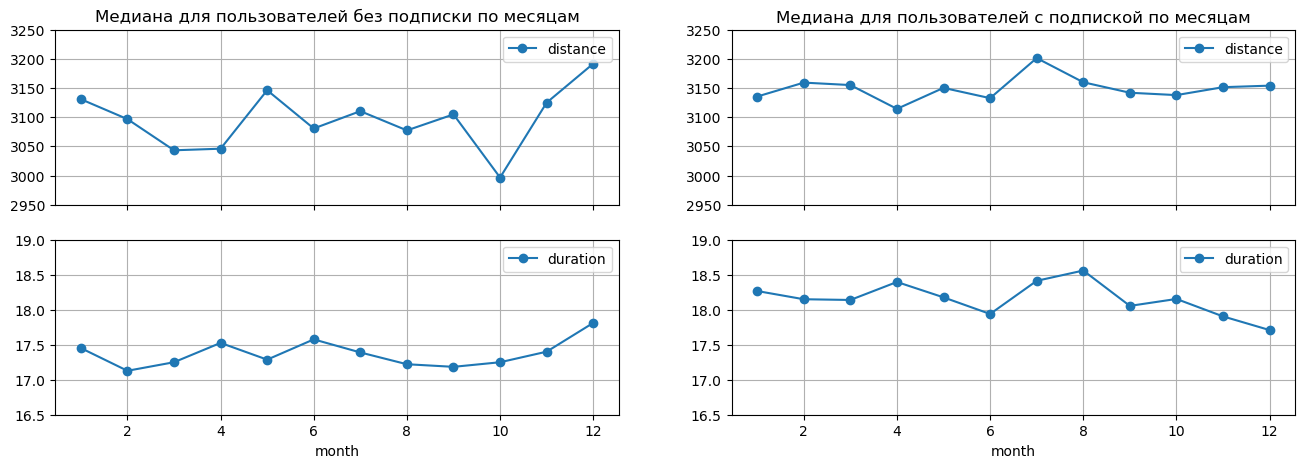

In [224]:
fig, axes = plt.subplots(nrows=2,
                         ncols=2,
                         sharex=True)
free_df.pivot_table(
    index='month',
    values='distance',
    aggfunc='median').plot(title = 'Медиана для пользователей без подписки по месяцам',
                           ylim=(2950, 3250), style='o-', grid=True, figsize=(16, 5 ), ax=axes[0][0])
ultra_df.pivot_table(
    index='month',
    values='distance',
    aggfunc='median').plot(title = 'Медиана для пользователей с подпиской по месяцам',
                           ylim=(2950, 3250), style='o-', grid=True, ax=axes[0][1])
free_df.pivot_table(
    index='month',
    values='duration', aggfunc='median').plot(ylim=(16.5, 19),
                                              style='o-',
                                              grid=True,
                                              ax=axes[1][0])
ultra_df.pivot_table(
    index='month',
    values='duration', aggfunc='median').plot(ylim=(16.5, 19),
                                              style='o-',
                                              grid=True,
                                              ax=axes[1][1]);

In [225]:
round(data.pivot_table(index='subscription_type',
                 values=['distance', 'duration'],
                 aggfunc='mean'), 1)

,distance,duration
subscription_type,,
free,3028.4,17.5
ultra,3115.4,18.5


Вывод:
- объединили 3 дата фрейма в один. Объединение прошло корректно, в новом объединенном датафрейме  17 973 строки и 12 колонок, которые содержат данные о пользователей, его поездках и типе подписки;
- разделили объединенный датафрейм на 2, где отдельно хранятся данные о пользователях, поездках и условиях подписки для клиентов с подпиской и без нее. Разделенные дата фреймы содержат идетничные 12 колонок, что и общий фрейм;
- существуют отличия в распределении расстояния поездок на самокате для пользователей с подпиской и без нее. На небольших расстояниях для пользователей с подпиской популяным можно назвать езду на расстояние около 1000 метров, в то время как для пользователей без подписки это диапазон 650-700 метров. У пользователей без подписки основной диапазон расстояний более широк - от 1500 местров до 7000, у пользователей с подпиской - от 2000 до 5000 метров распределены основные значения параметра. Выражены 3 пика распределения для пользователй с подпиской - около 1000, 3100 и 4000 метров. Дистанция поездки для пользователй без подписки распределены более равномерно, меньший пик около 650-700 метров, а также много значений распределены в диапазоне 2500 - 3500.
- длительность поездок для пользователей с подпиской и без нее распределены схожим образом. Пик значений для пользователей без подписки - 17-17.5 минут, для пользователей с подпиской - 18-18.5 минут.
- февраль и ноябрь - месяцы с "минимальным пробегом" для пользователей сервиса обеих категорий. Среди пользователей без подписки таким месяцем можно назвать еще и октябрь, а для пользователей с подпиской - сентябрь. 
- январь, май и декабрь - это месяца наибольшей активности пользователей - расстояние, которое они проезжают макисмальное по году. Для пользоватеей с подпиской самый продуктивный месяц - май - проехали 1 865 940 километров, без подписки - декабрь - проехали 3 114 655 километров.
- среднее расстояние, которое пользователь с подпиской проезжает в среднем за месяц варьируется в граница 3100-3200, в то время как пользователи без подписки имеют больший разброс в среднем расстоянии поездки от 3000 до 3200.
- среднее расстояние за поездку у пользователей с подпиской распределено более равномерно в течение года  с пиком в июле.
- средняя продолжительность поездки у пользователей без подписки меньше (3028.4 метров), чем у клиентов сервиса, оформивших подписку (3115.4 метров).
- средняя длительность поездки у пользователей без подписки меньше (17.5 минут), чем у клиентов сервиса, оформивших подписку (18.5 минут). Статистически ли достоверны отличия в продолжительности и длительности поезок для разных категорий пользователей проверим в следующем разделе.

### Подсчёт выручки

Посчитаем помесячную выручку, которую принес каждый пользователь: 
- создадим 2 датафрейма с агрегированными данными о поездках пользователей с подпиской и без подписки на основе фреймов `ultra_df` и `free_df`: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц;
- добавим столбец с помесячной выручкой, которая рассчитывается по формуле: стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки. Данные о длительности каждой сессии окрулим до большего целого числа.

In [226]:
#Помесячная выручка считается по формуле:
#стоимость старта поездки ×  количество поездок 
#+ стоимость одной минуты поездки × общая продолжительность всех поездок в минутах 
#+ стоимость подписки.

free_df['duration_ceil'] = np.ceil(free_df['duration'])

per_user_free = (free_df.groupby(['user_id', 'month']) \
                                     .agg({'distance': 'sum',
                                           'duration_ceil': 'sum',
                                           'name': 'count',
                                           'subscription_fee' : 'min',
                                           'minute_price': 'min',
                                           'start_ride_price': 'min'}) \
                                     .sort_values(['user_id', 'month']).reset_index())
per_user_free = per_user_free.rename(columns={'name': 'count'})
per_user_free['month_revenue'] = per_user_free['start_ride_price'] * per_user_free['count'] \
                                + per_user_free['minute_price'] * per_user_free['duration_ceil'] \
                                + per_user_free['subscription_fee']

#уберем технические столбцы
per_user_free = per_user_free[['user_id', 'month', 'distance', 'duration_ceil', 'count', 'month_revenue']]
per_user_free


/var/folders/5n/tcs__6sd74122_kzkls7z_lh0000gn/T/ipykernel_30795/3200959022.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,month,distance,duration_ceil,count,month_revenue
0,700,1,2515.690719,15.0,1,170.0
1,700,2,13446.659764,89.0,5,962.0
2,700,3,3798.334905,19.0,1,202.0
3,700,4,2984.551206,16.0,1,178.0
4,700,6,5927.650988,29.0,2,332.0
...,...,...,...,...,...,...
6762,1534,6,3409.468534,26.0,2,308.0
6763,1534,8,7622.453034,48.0,2,484.0
6764,1534,9,4928.173852,23.0,1,234.0
6765,1534,11,13350.015305,78.0,4,824.0


In [227]:
ultra_df['duration_ceil'] = np.ceil(ultra_df['duration'])

per_user_ultra = (ultra_df.groupby(['user_id', 'month']) \
                                     .agg({'distance': 'sum',
                                           'duration_ceil': 'sum',
                                           'name': 'count',
                                           'subscription_fee' : 'min',
                                           'minute_price': 'min',
                                           'start_ride_price': 'min'}) \
                                     .sort_values(['user_id', 'month']).reset_index())
per_user_ultra = per_user_ultra.rename(columns={'name': 'count'})
per_user_ultra['month_revenue'] = per_user_ultra['start_ride_price'] * per_user_ultra['count'] \
                                + per_user_ultra['minute_price'] * per_user_ultra['duration_ceil'] \
                                + per_user_ultra['subscription_fee']

per_user_ultra = per_user_ultra[['user_id', 'month', 'distance', 'duration_ceil', 'count', 'month_revenue']]
per_user_ultra

/var/folders/5n/tcs__6sd74122_kzkls7z_lh0000gn/T/ipykernel_30795/3456850770.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,month,distance,duration_ceil,count,month_revenue
0,1,1,7027.511294,42.0,2,451.0
1,1,4,754.159807,7.0,1,241.0
2,1,8,6723.470560,46.0,2,475.0
3,1,10,5809.911100,32.0,2,391.0
4,1,11,7003.499363,56.0,3,535.0
...,...,...,...,...,...,...
4528,699,6,4072.797406,17.0,1,301.0
4529,699,8,7018.324143,45.0,2,469.0
4530,699,9,6364.861911,31.0,2,385.0
4531,699,10,4707.845501,16.0,1,295.0


In [228]:
print('Средняя помесячная выручка от пользователя без подписки', round(per_user_free['month_revenue'].mean(), 1))

Средняя помесячная выручка от пользователя без подписки 329.3


In [229]:
print('Средняя помесячная выручка от пользователя c подпиской', round(per_user_ultra['month_revenue'].mean(), 1))

Средняя помесячная выручка от пользователя c подпиской 362.8


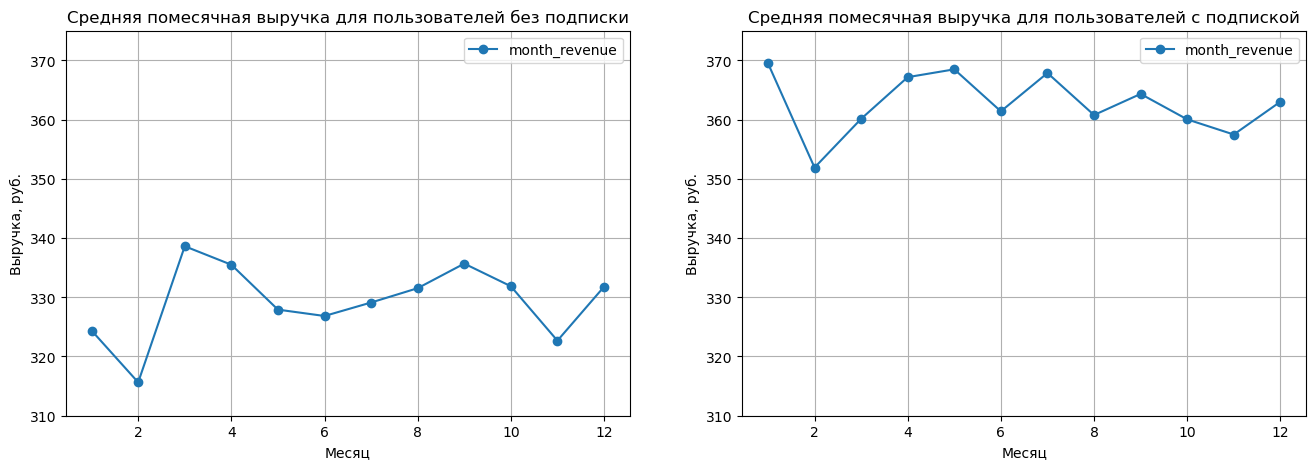

In [230]:
fig, axes = plt.subplots(nrows=1,
                         ncols=2,
                         sharex=True)

per_user_free.pivot_table(
    index='month',
    values='month_revenue',
    aggfunc='mean').plot(title = 'Средняя помесячная выручка для пользователей без подписки', 
                         xlabel='Месяц',
                         ylabel='Выручка, руб.',
                         ylim=(310, 375),
                         style='o-',
                         grid=True,
                         figsize=(16, 5 ), ax=axes[0]);

per_user_ultra.pivot_table(
    index='month',
    values='month_revenue',
    aggfunc='mean').plot(title = 'Средняя помесячная выручка для пользователей с подпиской',
                         xlabel='Месяц',
                         ylabel='Выручка, руб.',
                         ylim=(310, 375),
                         style='o-',
                         grid=True, ax=axes[1]);

Вывод: 
- создали 2 новый датафрейма, которые содержат данные об id пользователя, месяце поездки, расстоянию поездки, округленному до большего целого времи сессии, количество поездок в месяц и помесячные выручку каждого пользователя;
- данные для пользователей с подпиской и без подписки храним в разных фреймах `per_user_ultra` и `per_user_free`;
- средняя помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки. У подписчиков параметр варьируется от 351 до 370, в то время кау у пользователей без подписки средняя помесячная выручка находится в диапазоне 315 до 337. Статистически ли достоверны эти различия проверим на следуюшем этапе.

### Проверка гипотез

#### Гипотеза о среднем времени поездки
Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

- H0: длительность поездок клиентов без подписки и с подпиской равна
- H1: длительность поездки клиента c подпиской больше, чем у пользователя без подписки

In [231]:
alpha = 0.05

results = st.ttest_ind(ultra_df['duration'], free_df['duration'], alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.704468074453899e-28
Отвергаем нулевую гипотезу


In [232]:
# посчитаем среднюю продолжительность сессии для пользователя без подписки
free_duration_mean = free_df['duration'].mean()
print('Средняя длительность поездки без подписки', round(free_duration_mean, 1))

Средняя длительность поездки без подписки 17.5


In [233]:
free_duration_mean = ultra_df['duration'].mean()
print('Средняя длительность поездки без подписки', round(free_duration_mean, 1))

Средняя длительность поездки без подписки 18.5


**Вывод:** пользователи сервиса с подпиской и без подписки статистически достоверно тратят разное количество времени в среднем на поездку. На данной выборке удалось опровергнуть гипотезу о том, что среднее время поездок для пользователей с подпиской и без равное - пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. Среднее время сессии пользователя с подпиской  - 18.5 минут, пользователя без подписки - 17.5.

#### Гипотеза о среднем расстоянии в 3130
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

- H0 среднее расстояние, которое проезжает пользователь с подпиской за 1 поездку, равно 3130 местров
- H1 среднее расстояние, которое проезжает пользователь с подпиской за 1 поездку, более 3130 местров

In [234]:
distance_per_user = ultra_df['distance']
optimum_dist = 3130

alpha = 0.05

results = st.ttest_1samp(
    distance_per_user, 
    optimum_dist,
    alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


In [235]:
ultra_df['distance'].mean()

3115.4453880370247

**Вывод:** можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку около 3130 метров, данную гипотезу мы не смогли опровергнуть стат. тестом.

#### Гипотеза о помесячной выручке
Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

- H0 средняя помесячная выручка от пользователя с подпиской и без одинаковые
- H1 от пользователей c подпиской средняя помесячная выручка больше, чем от пользователя без подписки

In [236]:
alpha = 0.05

results = st.ttest_ind(per_user_ultra['month_revenue'],
                       per_user_free['month_revenue'],
                       alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


In [237]:
free_revenue = per_user_free['month_revenue'].mean()
print('Средняя месячная выручка от пользователя без подписки -', round(free_revenue, 1))

Средняя месячная выручка от пользователя без подписки - 329.3


In [238]:
ultra_revenue = per_user_ultra['month_revenue'].mean()
print('Средняя месячная выручка от пользователя с подпиской -', round(ultra_revenue, 1))

Средняя месячная выручка от пользователя с подпиской - 362.8


**Вывод:** в результате статистического теста были отвергнуты гипотезы о равенстве среднемесячной выручки от пользователя с подпиской и без подписки. Помесячная выручка от пользователей с подпиской по месяцам достоверно выше, чем выручка от пользователей без подписки. Средняя помесячная выручка от пользователей с подпиской 362.8 рубля, а от пользователя без подписки 329.3 рублей.

### Выводы

- в работу взяли 3 датафрейма, содержащие данные о пользователях, их поездках и типах подписок в 5, 4 и 4 колонки соответственно; 


- создали 2 новый датафрейма, которые содержат данные об id пользователя, месяце поездки, расстоянию поездки, округленному до большего целого времи сессии, количество поездок в месяц и помесячные выручку каждого пользователя;


- проверили наличие пропущенных значений (пропусков нет) и проверили наличие дубликатов в датафреймах - есть полные дубли в таблице users, удалили 31 строку-дубликат;


- в имеющейся выборке доля представленности пользователей из разных городов варьируется от 11 до 14%, что можно назвать примерно равными долями. Больше всего пользователей из Пятигорска (14.3%), меньше всего данных в выборке о пользователях из Москвы(11%);


- доля пользователней с подпиской, представленная в датасете - 54.4%, без подписки - 45.6%;


- средний возраст - 25 лет, и он одинаковый для пользователей с подпиской и без подписки;


- средняя дистанция, которую проезжает пользователь за сессию - 3060 метр;


- средняя продолжительность поездки - 17.9 минут.


- средняя помесячная выручка от подписчиков варьируется от 351 до 370, у пользователей без подписки значения параметра находится в диапазоне 315 до 337;


- январь, май и декабрь - это месяца наибольшей активности пользователей - расстояние, которое они проезжают в эти месяца максимальное по году. Для пользователей с подпиской самый продуктивный месяц - май - проехали 1 865 940 километров, без подписки - декабрь - проехали 3 114 655 километров. Февраль и ноябрь - месяцы с "минимальным пробегом" для пользователей сервиса обеих категорий. Среди пользователей без подписки таким месяцем можно назвать еще и октябрь, а для пользователей с подпиской - сентябрь;


- среднее расстояние, которое пользователь с подпиской проезжает в за месяц варьируется в граница 3100-3200 (медиана), в то время как пользователи без подписки имеют больший разброс в медианном расстоянии поездки от 3000 до 3200. Пользователи без подписки в октябре проезжают в среднем наименьшее расстояние за сессию по сравнению с остальным годом, максимальное - в декабре, среднее расстояние за поездку у пользователей с подпиской распределено более равномерно в течение года с пиком в июле.


- пользователи сервиса с подпиской тратят больше времени по поездку, чем пользователи без подписики. Среднее время сессии пользователя с подпиской  - 18.5 минут, пользователя без подписки - 17.5. На данной выборке удалось опровергнуть гипотезу о том, что среднее время поездок для пользователей с подпиской и без равное.


- можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку около 3130 метров, данную гипотезу мы не смогли опровергнуть стат. тестом.


- средняя помесячная выручка от пользователей с подпиской 362.8 рубля и она достоверно больше, чем от пользователей без подписки (среднее значение - 329.3 рублей). Данные отличия подтверждены статистически.